In [1]:

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
from sklearn.neural_network import MLPRegressor
from xgboost import XGBRegressor

from scipy.stats import randint, uniform, loguniform
from scikeras.wrappers import KerasRegressor
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping


import pandas as pd
import numpy as np
import warnings
import joblib
import random
import numpy as np
import tensorflow as tf

def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)

set_seed(42)


warnings.filterwarnings('ignore')

In [2]:
# Baca dataset
data = pd.read_csv('data_pmv_final.csv')
features = ["temperature", "humidity", "air_flow", "mrt"]
target = "pmv"

In [3]:
X = data[features]
y = data[target]

In [4]:

# Split 80% train dan 20% test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Verifikasi ukuran masing-masing set
print(f"Train size: {len(X_train)/len(X):.2%}")
print(f"Test size: {len(X_test)/len(X):.2%}")


Train size: 80.00%
Test size: 20.00%


In [5]:
# Normalisasi
scaler = MinMaxScaler()

# Fit scaler hanya pada X_train, dan transform X_train, dan X_test
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Verifikasi ukuran masing-masing set setelah normalisasi
print(f"Train size: {len(X_train_scaled)/len(X):.2%}")
print(f"Test size: {len(X_test_scaled)/len(X):.2%}")


Train size: 80.00%
Test size: 20.00%


In [6]:
# Fungsi evaluasi
def evaluate(y_train_true, y_train_pred, y_test_true, y_test_pred, model_name):
    df = pd.DataFrame({
        'Dataset': ['Train', 'Test'],
        'MAE': [
            mean_absolute_error(y_train_true, y_train_pred),
            mean_absolute_error(y_test_true, y_test_pred)
        ],
        'RMSE': [
            np.sqrt(mean_squared_error(y_train_true, y_train_pred)),
            np.sqrt(mean_squared_error(y_test_true, y_test_pred))
        ],
        'R2': [
            r2_score(y_train_true, y_train_pred),
            r2_score(y_test_true, y_test_pred)
        ]
    })

    print(f"\n=== {model_name} ===")
    print(df.to_string(index=False))

    return df


In [7]:
best_knn = KNeighborsRegressor(
    metric='euclidean',
    n_neighbors=3
)

# Latih model
best_knn.fit(X_train_scaled, y_train)
y_train_pred = best_knn.predict(X_train_scaled)
y_test_pred = best_knn.predict(X_test_scaled)

# Evaluasi hasil model
knn_results = evaluate(y_train, y_train_pred, y_test, y_test_pred, "KNN BEST MODEL")


=== KNN BEST MODEL ===
Dataset      MAE     RMSE       R2
  Train 0.016813 0.032547 0.998167
   Test 0.024752 0.045883 0.996290


In [8]:
best_rf = RandomForestRegressor(
    bootstrap=False,
    max_depth=None,
    max_features='sqrt',
    min_samples_leaf=2,
    min_samples_split=5,
    n_estimators=500,
    random_state=42,
    n_jobs=-1
)

# Latih model
best_rf.fit(X_train_scaled, y_train)

# Prediksi
y_train_pred = best_rf.predict(X_train_scaled)
y_test_pred = best_rf.predict(X_test_scaled)

# Evaluasi hasil model
rf_results = evaluate(y_train, y_train_pred, y_test, y_test_pred, "RF BEST MODEL")


=== RF BEST MODEL ===
Dataset      MAE     RMSE       R2
  Train 0.004604 0.011003 0.999791
   Test 0.012435 0.026618 0.998751


In [9]:
best_svr = SVR(
    kernel='rbf',
    C=1,
    epsilon=0.1
)

# Latih model
best_svr.fit(X_train_scaled, y_train)

# Prediksi
y_train_pred = best_svr.predict(X_train_scaled)
y_test_pred = best_svr.predict(X_test_scaled)

# Evaluasi hasil model
svr_results = evaluate(y_train, y_train_pred, y_test, y_test_pred, "SVR BEST MODEL")


=== SVR BEST MODEL ===
Dataset      MAE     RMSE       R2
  Train 0.038381 0.046822 0.996207
   Test 0.038437 0.046700 0.996157


In [10]:
# Inisialisasi model dengan parameter terbaik
best_xgb = XGBRegressor(
    n_estimators=1000,
    learning_rate=0.1,
    max_depth=7,
    min_child_weight=1,
    gamma=0,
    subsample=0.8,
    colsample_bytree=0.8,
    reg_alpha=0,
    reg_lambda=1,
    random_state=42,
    n_jobs=-1,
    verbosity=0
)

# Latih model
best_xgb.fit(X_train_scaled, y_train)

# Prediksi
y_train_pred = best_xgb.predict(X_train_scaled)
y_test_pred = best_xgb.predict(X_test_scaled)

# Evaluasi hasil model
xgb_results = evaluate(y_train, y_train_pred, y_test, y_test_pred, "XGBOOST BEST MODEL")


=== XGBOOST BEST MODEL ===
Dataset      MAE     RMSE       R2
  Train 0.002199 0.003062 0.999984
   Test 0.007255 0.017964 0.999431


In [11]:
# 5. MLP - Hyperparameter Tuning
print("\n=== Manual Tuning MLP Berdasarkan Batch Size dan Epochs ===")

# Fungsi build model
def build_mlp(hidden_1=256, hidden_2=128, hidden_3=64, hidden_4=32, dropout_rate=0.2, learning_rate=0.001):
  model = Sequential([
        Dense(hidden_1, activation='relu', input_shape=(X_train_scaled.shape[1],)),
        Dropout(dropout_rate),
        Dense(hidden_2, activation='relu'),
        Dropout(dropout_rate),
        Dense(hidden_3, activation='relu'),
        Dropout(dropout_rate),
        Dense(hidden_4, activation='relu'),
        Dropout(dropout_rate),
        Dense(1, activation='linear')
    ])
  model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mae')
  return model

# Kombinasi yang diuji
batch_sizes = [32, 64, 128]
epoch_list = [100, 200]

# Simpan hasil evaluasi
results = {}

for batch_size in batch_sizes:
    for epochs in epoch_list:
        print(f"\nTraining MLP dengan batch_size={batch_size}, epochs={epochs}...")

        model = build_mlp()

        early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

        history = model.fit(
            X_train_scaled, y_train,
            epochs=epochs,
            batch_size=batch_size,
            validation_split=0.2,
            verbose=0,
            callbacks=[early_stopping]
        )

        # Predict
        y_train_pred = model.predict(X_train_scaled).flatten()
        y_test_pred = model.predict(X_test_scaled).flatten()

        # Evaluasi
        result = evaluate(y_train, y_train_pred, y_test, y_test_pred,
                          f"MLP (Batch {batch_size}, Epochs {epochs})")

        # Simpan ke dictionary
        results[(batch_size, epochs)] = {
            'Train MAE': result['MAE'][0],
            'Test MAE': result['MAE'][1],
            'Train RMSE': result['RMSE'][0],
            'Test RMSE': result['RMSE'][1],
            'Train R2': result['R2'][0],
            'Test R2': result['R2'][1]
        }

# Ubah results jadi DataFrame
mlp_results = pd.DataFrame([
    {
        'Batch Size': batch_size,
        'Epochs': epochs,
        **metrics
    }
    for (batch_size, epochs), metrics in results.items()
])

print("\n=== Hasil Semua Kombinasi MLP ===")
print(mlp_results)



=== Manual Tuning MLP Berdasarkan Batch Size dan Epochs ===

Training MLP dengan batch_size=32, epochs=100...
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== MLP (Batch 32, Epochs 100) ===
Dataset      MAE     RMSE       R2
  Train 0.036423 0.049344 0.995787
   Test 0.036071 0.049222 0.995731

Training MLP dengan batch_size=32, epochs=200...
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== MLP (Batch 32, Epochs 200) ===
Dataset      MAE     RMSE       R2
  Train 0.029873 0.040496 0.997163
   Test 0.029781 0.040431 0.997119

Training MLP dengan batch_size=64, epochs=100...
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step

=== MLP (Batch 64, Epochs 100) ===
Dataset      MAE     RMSE       R2
  Train 0.026432 0.040635 0.997143
   Test 0.025934 0.039630 0.997232

Training MLP dengan batch_size=64, epochs=200...
652/652 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
163/163 ━━━━━━━━━━━━━━━━━━━━ 

In [12]:
# Cari kombinasi terbaik berdasarkan Test MAE (semakin kecil semakin bagus)
best_mlp = mlp_results.loc[mlp_results['Test MAE'].idxmin()]

print("\n=== Kombinasi MLP Terbaik berdasarkan Test MAE ===")
print(best_mlp)

# Format hasil akhir untuk digabung ke all_results
mlp_results = pd.DataFrame({
    'Dataset': ['Train', 'Test'],
    'MAE': [best_mlp['Train MAE'], best_mlp['Test MAE']],
    'RMSE': [best_mlp['Train RMSE'], best_mlp['Test RMSE']],
    'R2': [best_mlp['Train R2'], best_mlp['Test R2']],
    'Model': 'MLP'
})

print("\n=== Hasil Akhir MLP ===")
print(mlp_results)


=== Kombinasi MLP Terbaik berdasarkan Test MAE ===
Batch Size     64.000000
Epochs        100.000000
Train MAE       0.026432
Test MAE        0.025934
Train RMSE      0.040635
Test RMSE       0.039630
Train R2        0.997143
Test R2         0.997232
Name: 2, dtype: float64

=== Hasil Akhir MLP ===
  Dataset       MAE      RMSE        R2 Model
0   Train  0.026432  0.040635  0.997143   MLP
1    Test  0.025934  0.039630  0.997232   MLP


In [13]:
# Ambil parameter terbaik
optimal_batch = int(best_mlp['Batch Size'])
optimal_epoch = int(best_mlp['Epochs'])

# Bangun dan latih ulang model
model_mlp_best = build_mlp()

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model_mlp_best.fit(
    X_train_scaled, y_train,
    epochs=optimal_epoch,
    batch_size=optimal_batch,
    validation_split=0.2,
    verbose=0,
    callbacks=[early_stopping]
)

# Prediksi akhir yang valid
y_test_pred_mlp = model_mlp_best.predict(X_test_scaled).flatten()


163/163 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [14]:
# KNN
y_test_pred_knn = best_knn.predict(X_test_scaled)

# Random Forest
y_test_pred_rf = best_rf.predict(X_test_scaled)

# SVR
y_test_pred_svr = best_svr.predict(X_test_scaled)

# XGBoost
y_test_pred_xgb = best_xgb.predict(X_test_scaled)

# MLP
y_test_pred_mlp = model_mlp_best.predict(X_test_scaled).flatten()


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


In [15]:

# Menambahkan nama model ke hasil evaluasi masing-masing
knn_results['Model'] = 'KNN'
rf_results['Model'] = 'Random Forest'
svr_results['Model'] = 'SVR'
xgb_results['Model'] = 'XGBoost'
mlp_results['Model'] = 'MLP'

# Gabungkan semua hasil evaluasi
all_results = pd.concat([knn_results, rf_results, svr_results, xgb_results, mlp_results], ignore_index=True)


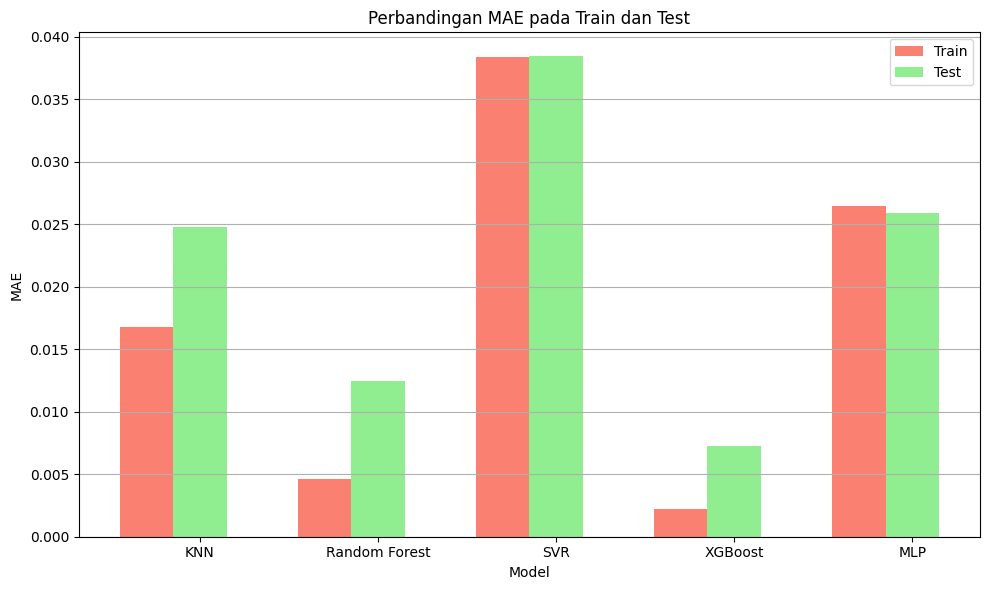

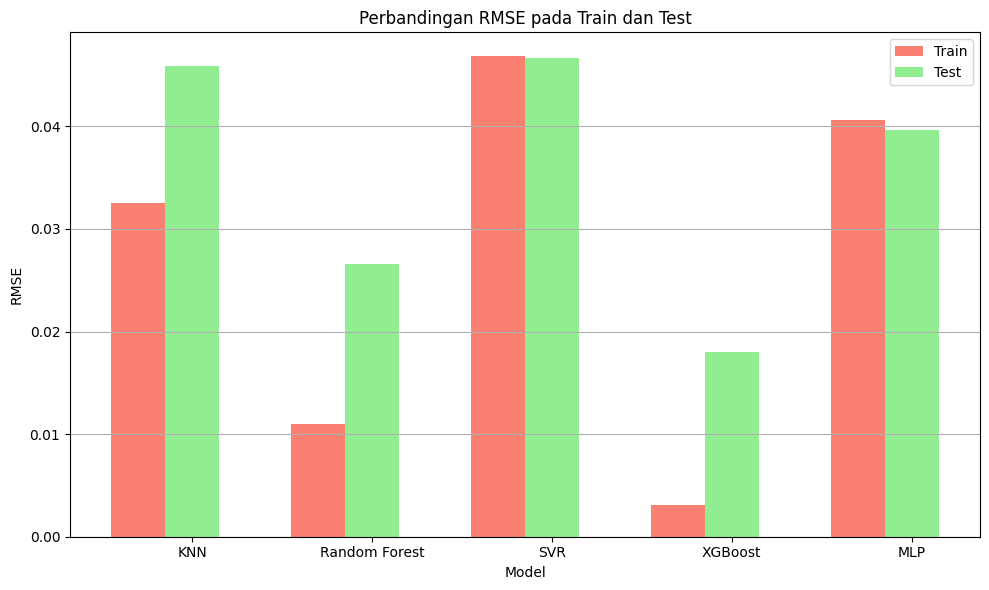

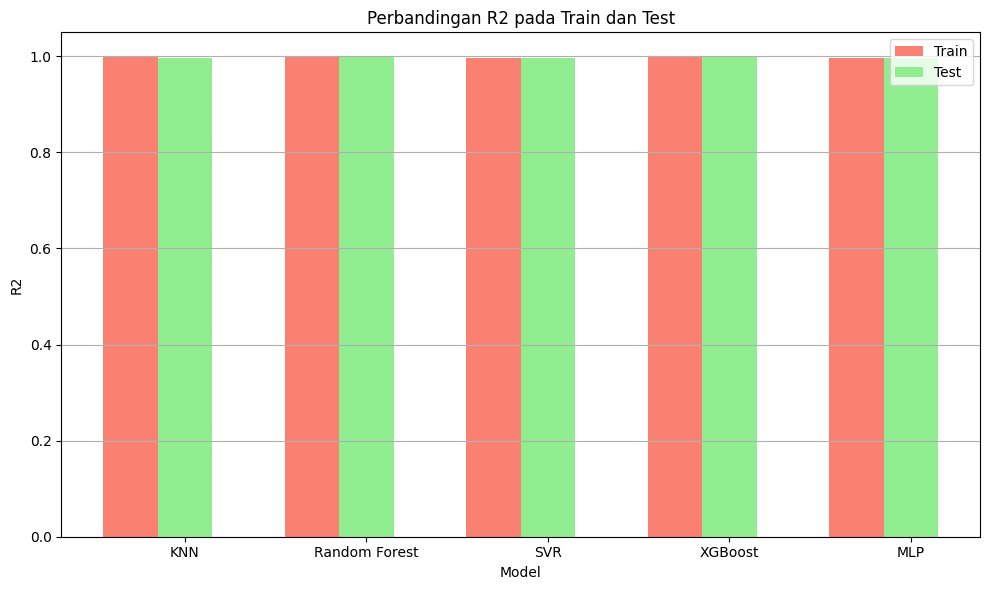

In [16]:
import matplotlib.pyplot as plt
import numpy as np

# Buat list metric dan dataset
metrics = ['MAE', 'RMSE', 'R2']
datasets = ['Train', 'Test']
colors = ['salmon', 'lightgreen']

# Loop setiap metric
for metric in metrics:
    plt.figure(figsize=(10,6))

    models = all_results['Model'].unique()
    x = np.arange(len(models))
    width = 0.3

    for i, dataset in enumerate(datasets):
        subset = all_results[all_results['Dataset'] == dataset]
        plt.bar(
            x + (i - 1) * width,
            subset[metric],
            width=width,
            label=dataset,
            color=colors[i]
        )

    plt.xticks(x, models)
    plt.title(f'Perbandingan {metric} pada Train dan Test')
    plt.xlabel('Model')
    plt.ylabel(metric)
    plt.legend()
    plt.grid(True, axis='y')
    plt.tight_layout()
    plt.show()


In [18]:
# === Membandingkan Semua Model Secara Lengkap ===

# 1. Train Set - Berdasarkan MAE
print("\n=== PERBANDINGAN TRAIN SET BERDASARKAN MAE (Semakin kecil semakin bagus) ===")
train_results = all_results[all_results['Dataset'] == 'Train']
print(train_results.sort_values('MAE')[['Model', 'MAE', 'RMSE', 'R2']].to_string(index=False))

# 2. Train Set - Berdasarkan RMSE
print("\n=== PERBANDINGAN TRAIN SET BERDASARKAN RMSE (Semakin kecil semakin bagus) ===")
print(train_results.sort_values('RMSE')[['Model', 'MAE', 'RMSE', 'R2']].to_string(index=False))

# 3. Train Set - Berdasarkan R2 Score 
print("\n=== PERBANDINGAN TRAIN SET BERDASARKAN R2 (Semakin tinggi semakin bagus) ===")
print(train_results.sort_values('R2', ascending=False)[['Model', 'MAE', 'RMSE', 'R2']].to_string(index=False))

test_results = all_results[all_results['Dataset'] == 'Test']
# 4. Test Set - Berdasarkan MAE
print("\n=== PERBANDINGAN TEST SET BERDASARKAN MAE (Semakin kecil semakin bagus) ===")
print(test_results.sort_values('MAE')[['Model', 'MAE', 'RMSE', 'R2']].to_string(index=False))

# 5. Test Set - Berdasarkan RMSE
print("\n=== PERBANDINGAN TEST SET BERDASARKAN RMSE (Semakin kecil semakin bagus) ===")
print(test_results.sort_values('RMSE')[['Model', 'MAE', 'RMSE', 'R2']].to_string(index=False))

# 6. Test Set - Berdasarkan R2 Score
print("\n=== PERBANDINGAN TEST SET BERDASARKAN R2 (Semakin tinggi semakin bagus) ===")
print(test_results.sort_values('R2', ascending=False)[['Model', 'MAE', 'RMSE', 'R2']].to_string(index=False))



=== PERBANDINGAN TRAIN SET BERDASARKAN MAE (Semakin kecil semakin bagus) ===
        Model      MAE     RMSE       R2
      XGBoost 0.002199 0.003062 0.999984
Random Forest 0.004604 0.011003 0.999791
          KNN 0.016813 0.032547 0.998167
          MLP 0.026432 0.040635 0.997143
          SVR 0.038381 0.046822 0.996207

=== PERBANDINGAN TRAIN SET BERDASARKAN RMSE (Semakin kecil semakin bagus) ===
        Model      MAE     RMSE       R2
      XGBoost 0.002199 0.003062 0.999984
Random Forest 0.004604 0.011003 0.999791
          KNN 0.016813 0.032547 0.998167
          MLP 0.026432 0.040635 0.997143
          SVR 0.038381 0.046822 0.996207

=== PERBANDINGAN TRAIN SET BERDASARKAN R2 (Semakin tinggi semakin bagus) ===
        Model      MAE     RMSE       R2
      XGBoost 0.002199 0.003062 0.999984
Random Forest 0.004604 0.011003 0.999791
          KNN 0.016813 0.032547 0.998167
          MLP 0.026432 0.040635 0.997143
          SVR 0.038381 0.046822 0.996207

=== PERBANDINGAN TEST SET 

In [19]:
# Mencari model terbaik berdasarkan masing-masing metrik
best_mae_model = test_results.loc[test_results['MAE'].idxmin()]
best_rmse_model = test_results.loc[test_results['RMSE'].idxmin()]
best_r2_model   = test_results.loc[test_results['R2'].idxmax()]

print("\n=== MODEL DENGAN MAE TERKECIL (Test Set) ===")
print(best_mae_model)

print("\n=== MODEL DENGAN RMSE TERKECIL (Test Set) ===")
print(best_rmse_model)

print("\n=== MODEL DENGAN R2 TERTINGGI (Test Set) ===")
print(best_r2_model)



=== MODEL DENGAN MAE TERKECIL (Test Set) ===
Dataset        Test
MAE        0.007255
RMSE       0.017964
R2         0.999431
Model       XGBoost
Name: 7, dtype: object

=== MODEL DENGAN RMSE TERKECIL (Test Set) ===
Dataset        Test
MAE        0.007255
RMSE       0.017964
R2         0.999431
Model       XGBoost
Name: 7, dtype: object

=== MODEL DENGAN R2 TERTINGGI (Test Set) ===
Dataset        Test
MAE        0.007255
RMSE       0.017964
R2         0.999431
Model       XGBoost
Name: 7, dtype: object


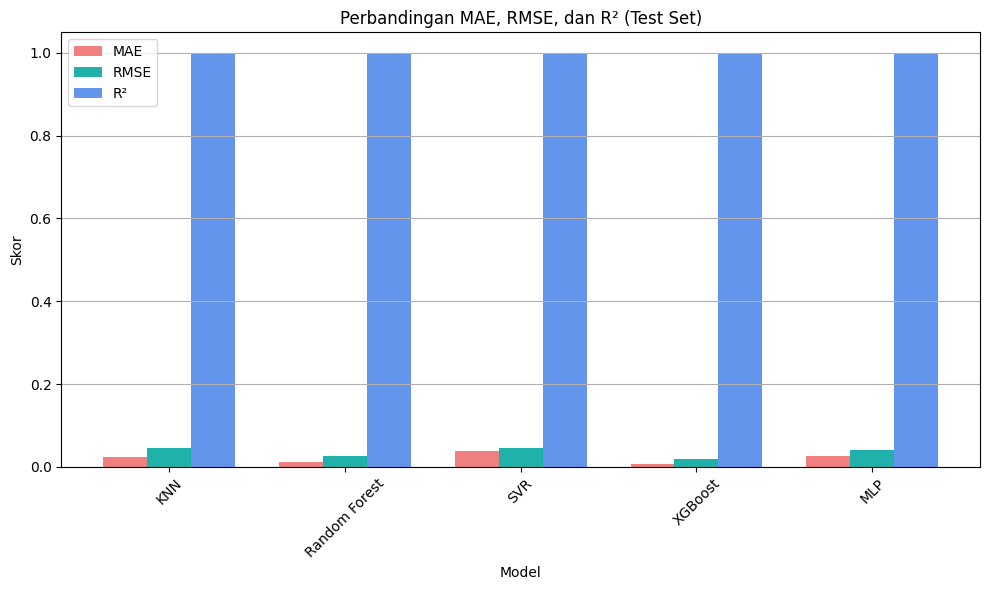

In [20]:
import numpy as np

# Grouped Bar Chart untuk MAE, RMSE, R2 di Test Set
x = np.arange(len(test_results['Model']))
width = 0.25  

fig, ax = plt.subplots(figsize=(10,6))

rects1 = ax.bar(x - width, test_results['MAE'], width, label='MAE', color='lightcoral')
rects2 = ax.bar(x, test_results['RMSE'], width, label='RMSE', color='lightseagreen')
rects3 = ax.bar(x + width, test_results['R2'], width, label='R²', color='cornflowerblue')

ax.set_xlabel('Model')
ax.set_ylabel('Skor')
ax.set_title('Perbandingan MAE, RMSE, dan R² (Test Set)')
ax.set_xticks(x)
ax.set_xticklabels(test_results['Model'])
ax.legend()
ax.grid(axis='y')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


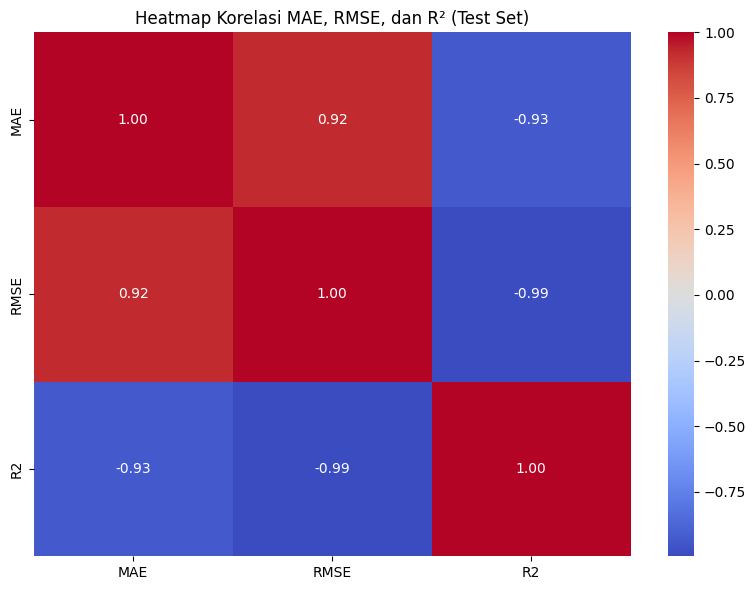

In [21]:
import seaborn as sns

# Fokus hanya ke metrik
test_metrics_only = test_results[['MAE', 'RMSE', 'R2']].copy()
test_metrics_only.index = test_results['Model'] 

plt.figure(figsize=(8,6))
sns.heatmap(test_metrics_only.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Heatmap Korelasi MAE, RMSE, dan R² (Test Set)')
plt.tight_layout()
plt.show()


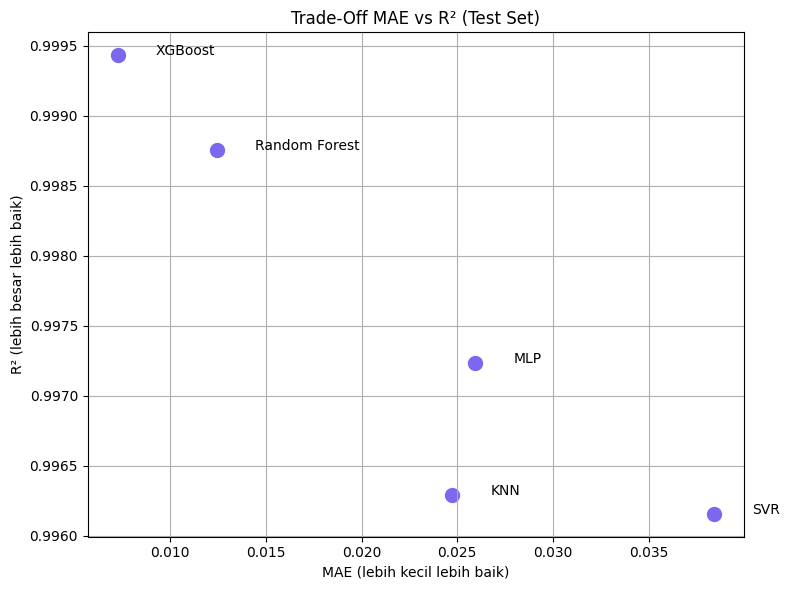

In [22]:
plt.figure(figsize=(8,6))
plt.scatter(test_results['MAE'], test_results['R2'], s=100, color='mediumslateblue')

for i, model in enumerate(test_results['Model']):
    plt.text(test_results['MAE'].iloc[i]+0.002, test_results['R2'].iloc[i], model)

plt.xlabel('MAE (lebih kecil lebih baik)')
plt.ylabel('R² (lebih besar lebih baik)')
plt.title('Trade-Off MAE vs R² (Test Set)')
plt.grid(True)
plt.tight_layout()
plt.show()


In [23]:
import joblib
joblib.dump(best_xgb, "xgb_model.pkl")
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']